#Taken John Hopkins dataset available on Kaggle for Analysis and Prediction

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"poulomisen","key":"8d09a8d6169d697dd23bb82bdf5a5897"}'}

In [0]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json 

In [0]:
! kaggle datasets download --force -d brendaso/2019-coronavirus-dataset-01212020-01262020

401 - Unauthorized


In [0]:
!unzip -q 2019-coronavirus-dataset-01212020-01262020.zip -d Covid_19_dataset

In [0]:
# Installed all the libraries required
!pip install pycountry_convert 
!pip install folium
!pip install calmap
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths_v2.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed_v2.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_usa_c.h5

--2020-04-22 15:42:09--  https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths_v2.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194280 (190K) [application/octet-stream]
Saving to: ‘model_deaths_v2.h5.1’

model_deaths_v2.h5. 100%[===================>] 189.73K  --.-KB/s    in 0.04s   

2020-04-22 15:42:10 (4.27 MB/s) - ‘model_deaths_v2.h5.1’ saved [194280/194280]

--2020-04-22 15:42:11--  https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed_v2.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... conn

In [0]:
#imported all the required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##Loading Dataset

In [0]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated dataset
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])


In [0]:
# new dataset after dropping few columns
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head()


,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Australia,2020-04-22 14:38:31,-25.0000,133.0000,6547,67,4124,2356,25.715150
1,Austria,2020-04-22 14:30:32,47.5162,14.5501,14925,510,11328,3087,165.715491
2,Canada,2020-04-22 14:38:15,60.0010,-95.0010,39405,1915,13190,24300,104.092641
3,China,2020-04-22 12:28:25,30.5928,114.3055,83868,4636,77861,1371,5.970628
4,Denmark,2020-04-22 14:30:32,56.0000,10.0000,8108,384,5276,2448,139.981282


In [0]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24


##Preprocessing

In [0]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]



In [0]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"



df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"


df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"


df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"


df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"


df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"


df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"


df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"


df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"


# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
  

In [0]:
df_table = df_table[df_table["continent"] != "Others"]

In [0]:
df_deaths[df_deaths["continent" ]== 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
88,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,3,3,...,7,7,7,7,7,7,7,7,8,8,8,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,13,13,13,13,13
127,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,3,3,4
247,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,4,5,5,7,7,7,7,8,8,11,12,12,12,12,12
248,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,3,3,3,3,4,4,4,4,4,4,5,5,5,5
252,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
261,NaN,Western Sahara,Others,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
df_confirmed
df_deaths

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,,Afghanistan,Asia,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36,36
1,,Albania,Europe,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26,26
2,,Algeria,Africa,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384,392
3,,Andorra,Europe,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37,37
4,,Angola,Africa,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,Europe,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,,South Sudan,Africa,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
261,,Western Sahara,Others,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262,,Sao Tome and Principe,Africa,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Functions

In [0]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
 
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
   
    plt.title( plt_title,{'fontsize':title_fsize})
    plt.yscale(scale)
    plt.minorticks_on()
   
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))

        ax = f.add_subplot(111)
    else :
        f = figure[0]
       
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["orange","red"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
   
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
   
    plot_params(ax,axis_label,scale = scale)
    
   
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
   
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""

#Analysis of Data


Getting country wise and continent wise data.

In [0]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

Global Reported Cases till today 



In [0]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t


,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
0,2593129.0,179725.0,696948.0,1716456.0,12349.483208,6.93


Report of each continent till today


In [0]:
df_continents_cases["Mortality Rate per 100"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
continent,,,,,,
Africa,25125,1202,6550,17373,245.153401,4.78
Asia,416564,15674,196159,204731,1439.532229,3.76
Australia,8024,81,5168,2775,57.902293,1.01
Europe,1161376,109936,355617,695823,8488.362921,9.47
North America,888495,48452,92910,747133,725.354770,5.45
Others,1864,36,818,1010,1152.918525,1.93
South America,91681,4344,39726,47611,240.259068,4.74


### Country Wise Reported Cases
Country Wise reported confirmed cases, recovered cases, deaths, active cases

In [0]:
df_countries_cases["Mortality Rate per 100"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Confirmed', ascending= False)

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100),Mortality Rate per 100
country,,,,,,,
USA,826184,45150,75682,705352,250.764355,5.46,5.46
Spain,208389,21717,85915,100757,445.706271,10.42,10.42
Italy,183957,24648,51600,107709,304.253123,13.40,13.40
France,159300,20829,39842,98629,244.049991,13.08,13.08
Germany,148925,5117,99400,44408,177.748852,3.44,3.44
...,...,...,...,...,...,...,...
Bhutan,6,0,2,4,0.777593,0.00,0.00
Western Sahara,6,0,0,6,1.004470,0.00,0.00
South Sudan,4,0,0,4,0.035734,0.00,0.00


### Top 10 countries (Confirmed and Deaths)

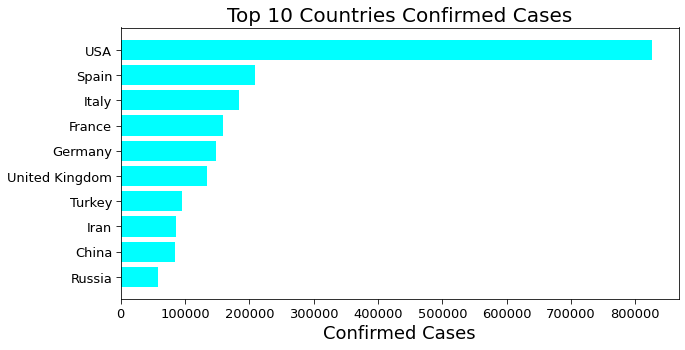

In [0]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="cyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries Confirmed Cases",fontsize=20)
plt.savefig(out+'Top 10 Countries Confirmed Cases.png')

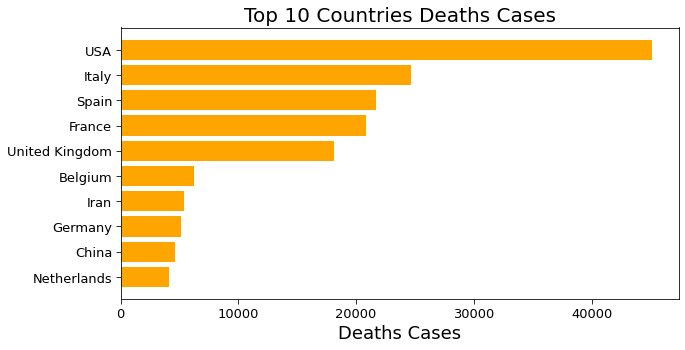

In [0]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="orange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries Deaths Cases",fontsize=20)

plt.savefig(out+'Top 10 Countries Deaths Cases.png')

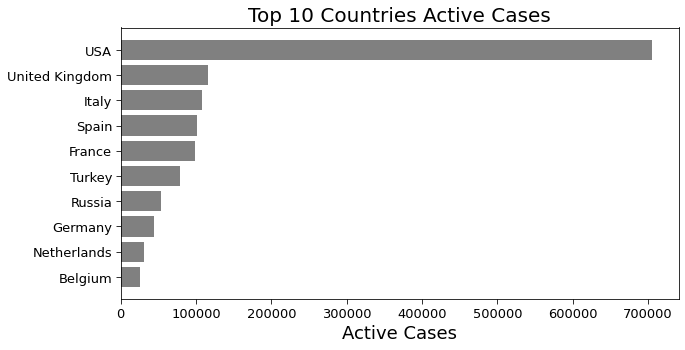

In [0]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="grey")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries Active Cases",fontsize=20)

plt.savefig(out+'Top 10 Countries Active Cases.png')

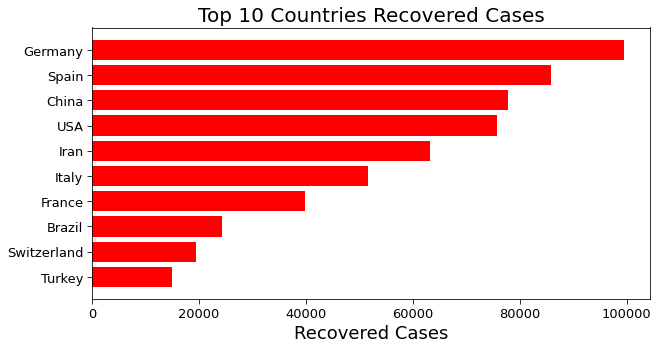

In [0]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="red")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries Recovered Cases",fontsize=20)

plt.savefig(out+'Top 10 Countries Recovered Cases.png')

##Data Visualization On World Map

In [0]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map


Global Confirmed Cases Heat Map

In [0]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Confirmed"]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.show()

Global Deaths Heat Map

In [0]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Deaths"]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.show()

Global Recovered Heat Map

In [0]:
temp_df = pd.DataFrame(df_countries_cases['Recovered'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Recovered"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.show()

 Spread Progression

In [0]:
df_data = df_table.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index()
df_data["Last_Update"] = pd.to_datetime( df_data["Last_Update"]).dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(df_data, locations="Country_Region", locationmode='country names', 
                     color=np.power(df_data["Confirmed"],0.3)-2 , size= np.power(df_data["Confirmed"]+1,0.3)-1, hover_name="Country_Region",
                     hover_data=["Confirmed"],
                     range_color= [0, max(np.power(df_data["Confirmed"],0.3))], 
                     projection="natural earth", animation_frame="Last_Update", 
                     color_continuous_scale=px.colors.sequential.Plasma
                    )
fig.show()

Spread Analysis

1. Cases over the world Number  :

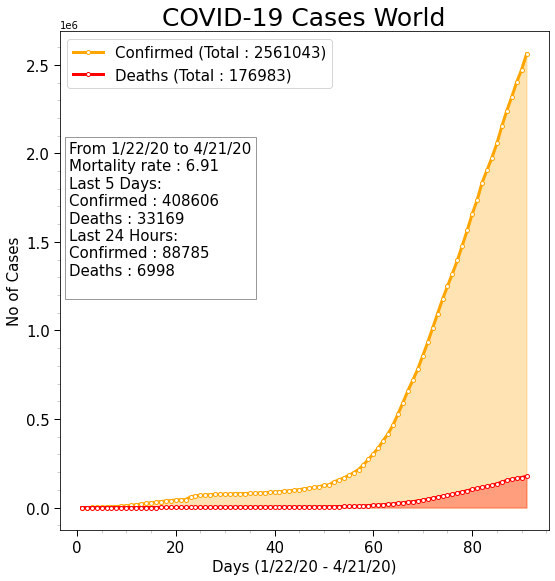

In [0]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))

visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

plt.savefig(out+'COIVD-19-World.png')
plt.show()

2 . COVID-19 Spread Trends in Different Continents

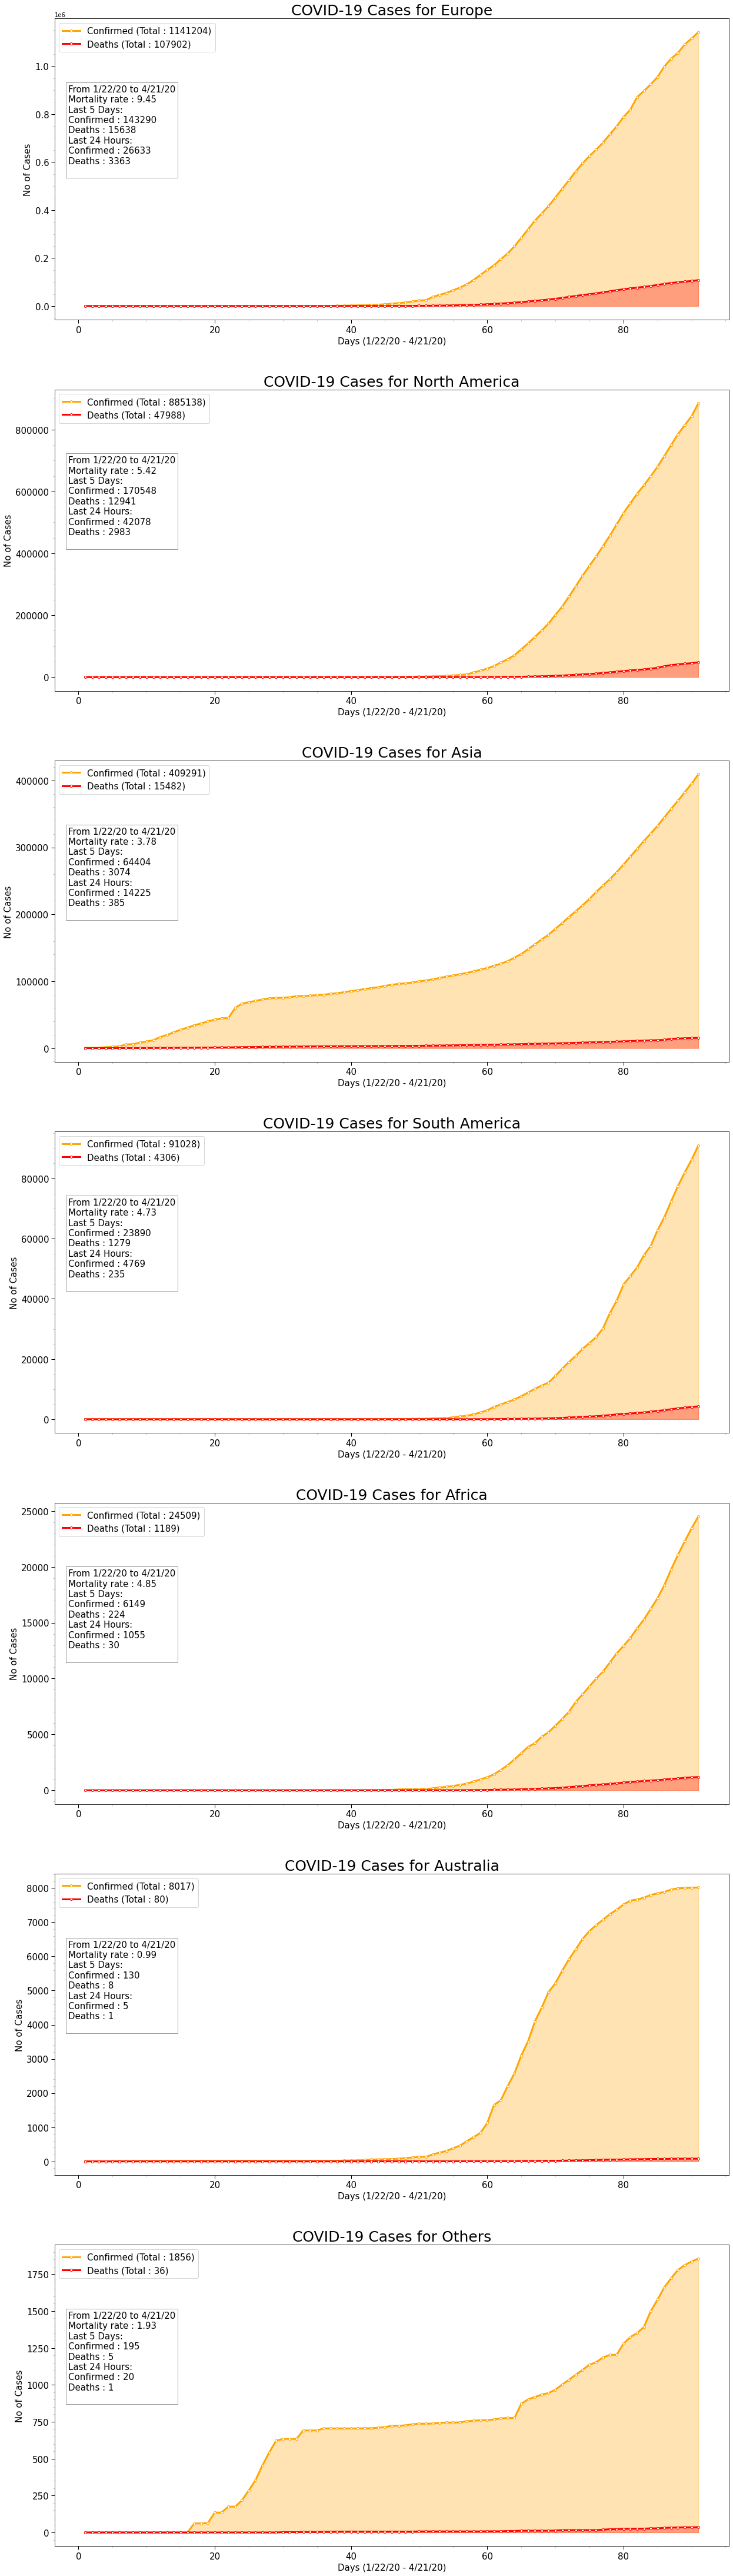

In [0]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index

cols =1
rows = int(np.ceil(continents.shape[0]/cols))
f = plt.figure(figsize=(20,9*rows))
for i,continent in enumerate(continents):
    visualize_covid_cases(df_confirmed, df_deaths, continent = continent,figure = [f,rows,cols, i+1])

plt.show()

3. COVID-19 Spread Comparison of in different continents

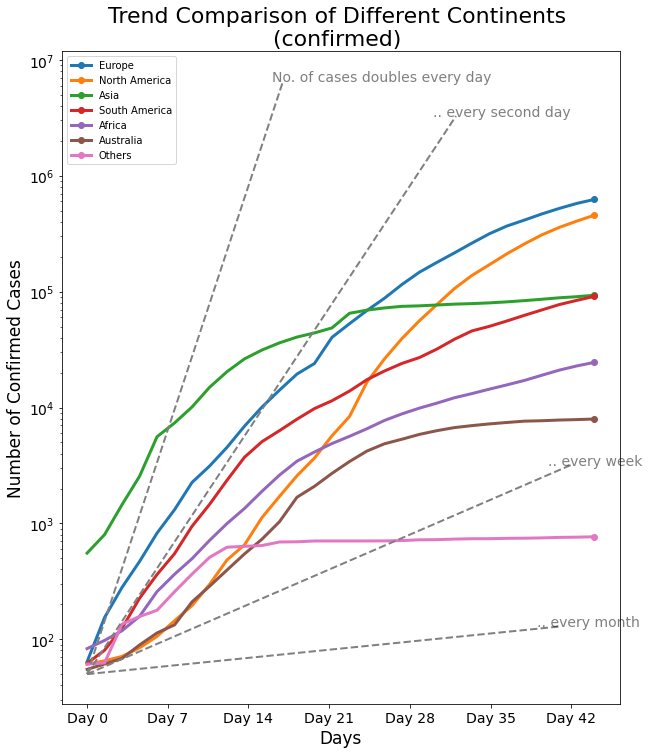

In [0]:
temp = df_confirmed.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-2)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.savefig(out+'Trend Comparison of continents (Confirmed).png')
plt.show()

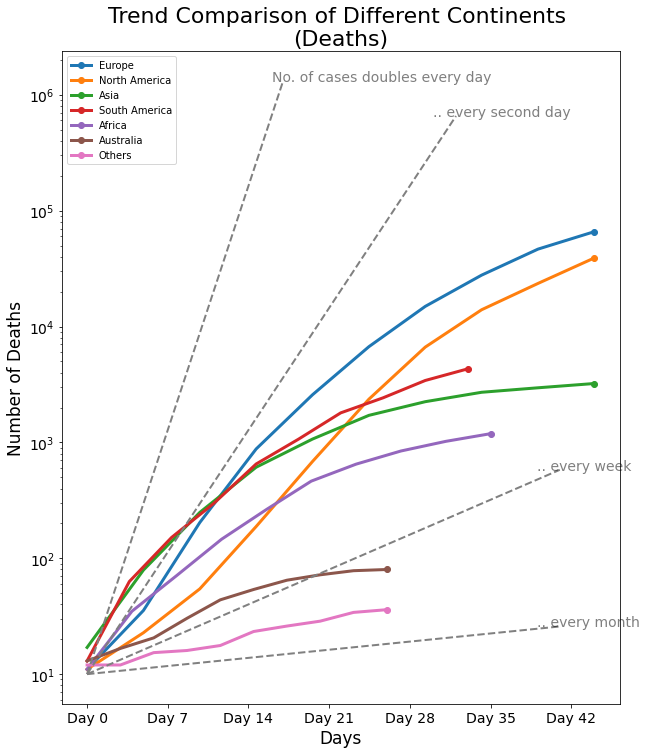

In [0]:
temp = df_deaths.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 10)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     


x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.savefig(out+'Trend Comparison continents (deaths).png')
plt.show()

In [0]:
#Prediction 

In [0]:
data_y = np.log10(np.asarray(df_confirmed.iloc[:,5:].sum(axis =0)).astype("float32"))
data_x = np.arange(1,len(data_y)+1)

In [0]:
model = models.load_model("model_confirmed_v2.h5")
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l3 (LeakyReLU)         (None, 80)                0   

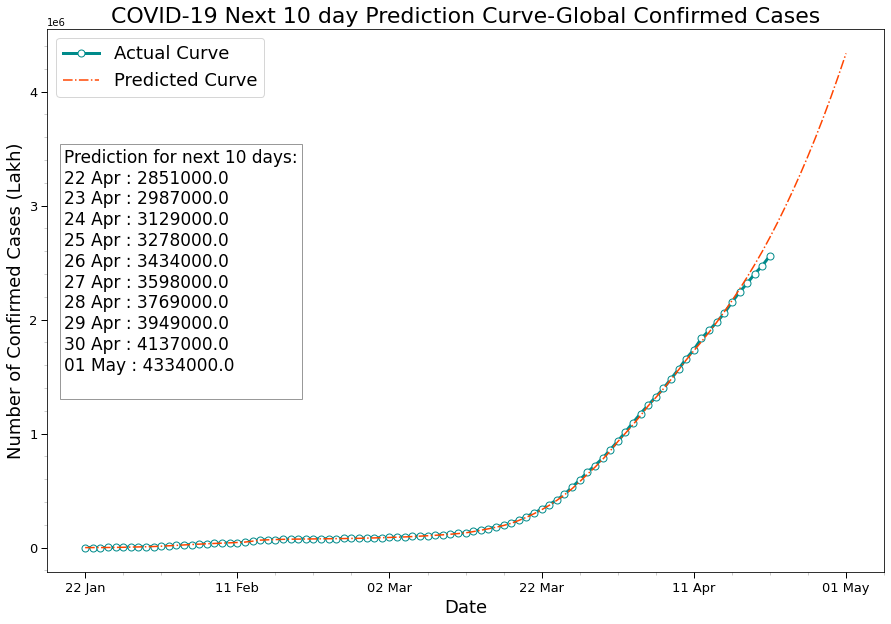

In [0]:
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]


prediction_days = 10

temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
data = np.power(10,model.predict(np.arange(1,len(temp_data)+prediction_days+1)))
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data,"-.",color="darkcyan",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total = d + nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0])+" \n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))


plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),d[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')


plt.title("COVID-19 Next 10 day Prediction Curve-Global Confirmed Cases",{'fontsize':22})


plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases (Lakh)",fontsize =18)

plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve-Confirmed.png")
plt.show()

In [0]:
data1_y = np.log10(np.asarray(df_deaths.iloc[:,5:].sum(axis =0)).astype("float32"))
data1_x = np.arange(1,len(data1_y)+1)

In [0]:
model2 = models.load_model("model_deaths_v2.h5")
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l3 (LeakyReLU)         (None, 80)                0   

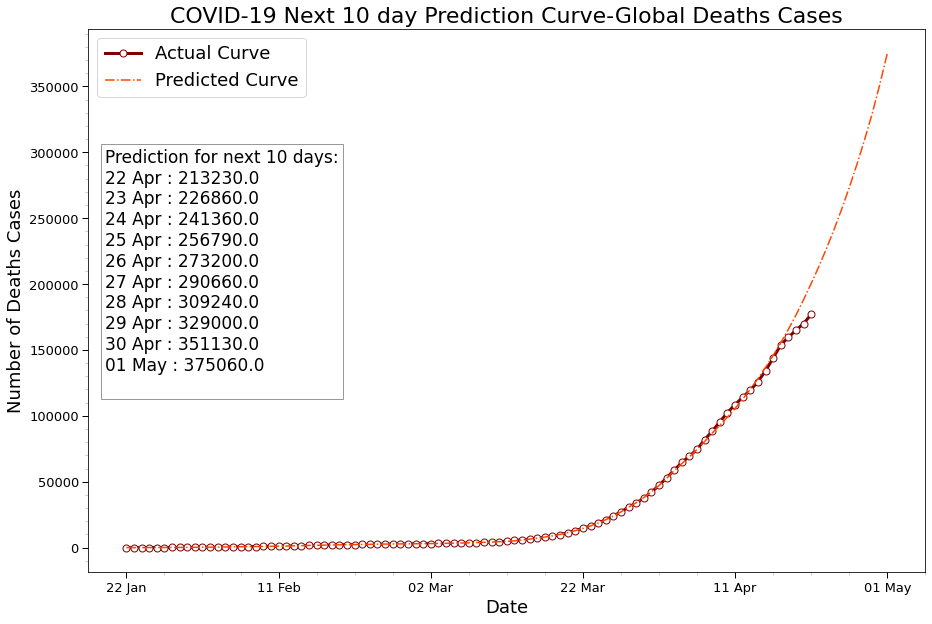

In [0]:

prediction_days = 10

temp_data = df_deaths.iloc[:,5:].sum(axis =0)
data = np.power(10,model2.predict(np.arange(1,len(temp_data)+prediction_days+1)))
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data,"-.",color="maroon",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-1)[0])+"\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))


plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')


plt.title("COVID-19 Next 10 day Prediction Curve-Global Deaths Cases",{'fontsize':22})


plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Deaths Cases",fontsize =18)


plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve2.png")
plt.show()

## Tabulation of prediction and actual figure after 15 th April 

In [0]:
start_date = "4/15/20"
sd= dd(start_date,"1/22/20")
nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays
data_confirmed = np.power(10,model.predict(np.arange(1,len(data_y)+prediction_days+1)))
data_deaths = np.power(10,model2.predict(np.arange(1,len(data_y)+prediction_days+1)))
pd.DataFrame([total[sd:],
              list(np.int64(np.round(data_confirmed[sd:].reshape(-1),2))),
              list(df_confirmed.iloc[:,5:].sum(axis =0)[sd:]),
              list(np.int64(np.round(data_deaths[sd:].reshape(-1),2))),
             list(df_deaths.iloc[:,5:].sum(axis =0)[sd:])],
             ["Date","Confirmed(Predicted)","Confirmed(Actual)","Deaths(Predicted)","Deaths(Actual)"]
            ).transpose().set_index("Date")

,Confirmed(Predicted),Confirmed(Actual),Deaths(Predicted),Deaths(Actual)
Date,,,,
15 Apr,2068264,2056054,136731,134189
16 Apr,2165009,2152437,145826,143814
17 Apr,2266268,2240190,155423,153835
18 Apr,2371988,2317758,165639,159509
19 Apr,2482579,2401378,176526,165043
20 Apr,2598432,2472258,188130,169985
21 Apr,2721729,2561043,200415,176983
22 Apr,2851017,None,213226,None
23 Apr,2986578,None,226856,None


Daily New Confirmed Cases and Deaths

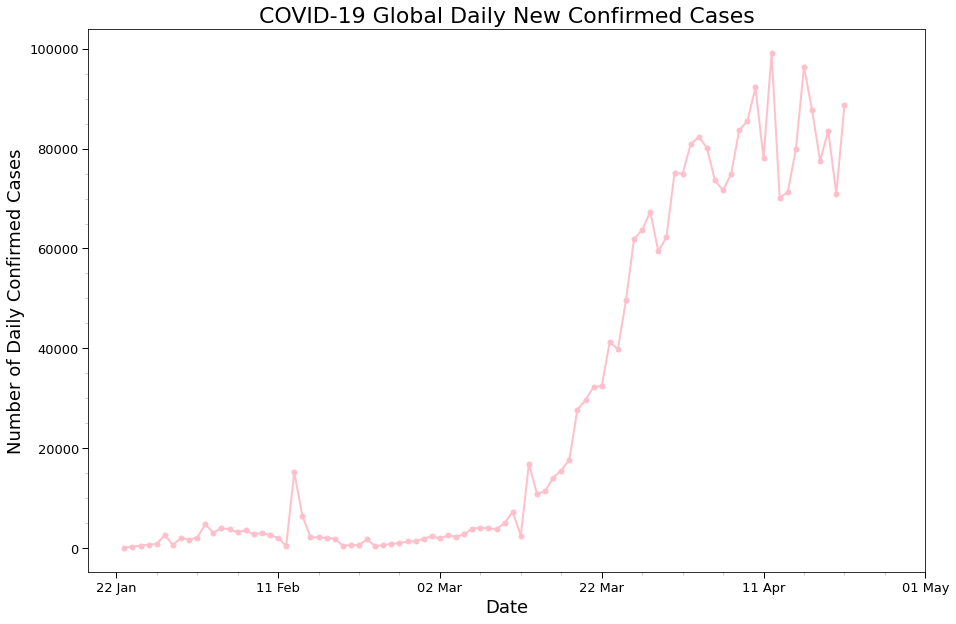

In [0]:
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())

f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data,"-.",color="pink",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')


plt.title("COVID-19 Global Daily New Confirmed Cases",{'fontsize':22})


plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases",fontsize =18)


plt.tick_params(labelsize = 13) 
plt.savefig(out+"daily confirmed cases global.png")
plt.show()

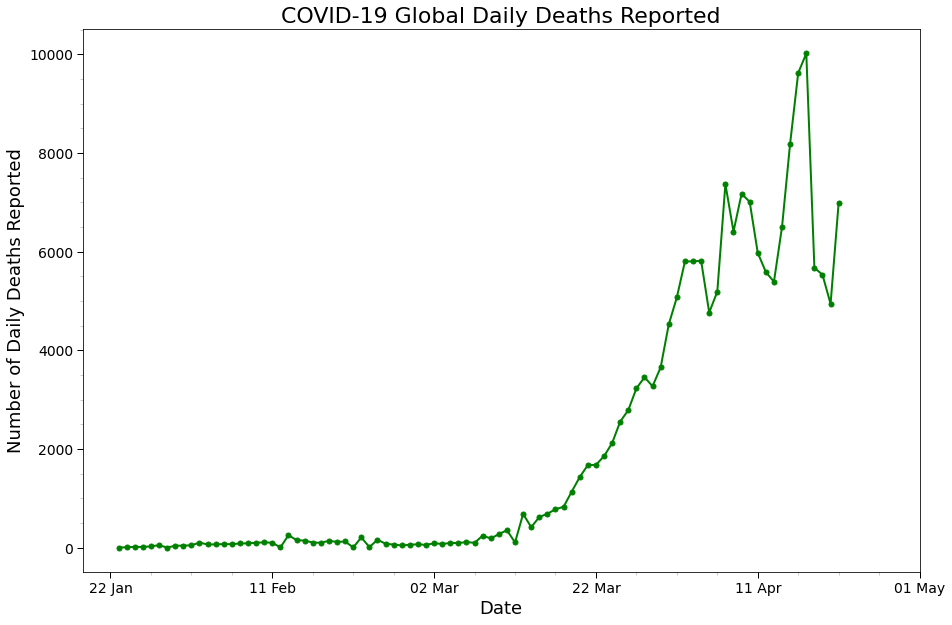

In [0]:
temp_data = np.nan_to_num(df_deaths.sum()[5:].diff())


f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data,"-.",color="green",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays


plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')


plt.title("COVID-19 Global Daily Deaths Reported",{'fontsize':22})


plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported",fontsize =18)


plt.savefig(out+"daily deaths cases Global.png")
plt.show()

New Confirmed and death cases in different countries

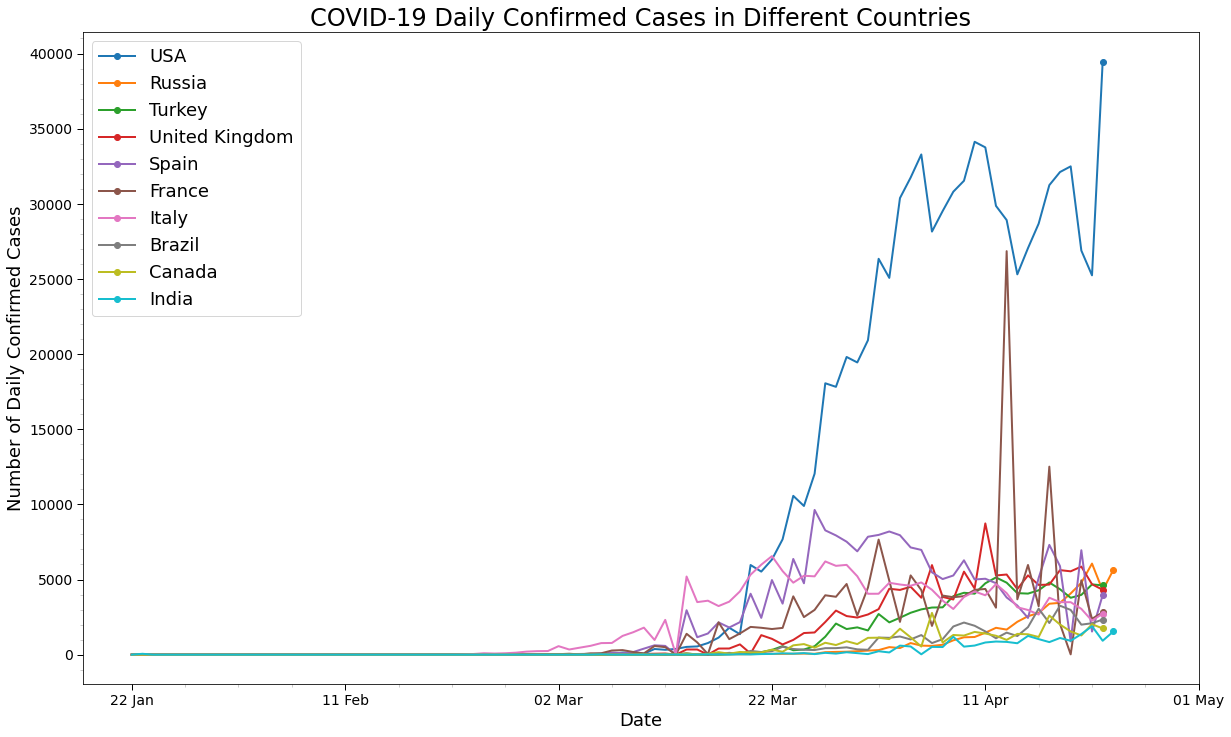

In [0]:
temp = df_confirmed.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays


plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')


plt.title("COVID-19 Daily Confirmed Cases in Different Countries",{'fontsize':24})


plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases",fontsize =18)


plt.legend(fontsize=18) 
plt.savefig(out+"daily confirmed cases countrywise.png")
plt.show()

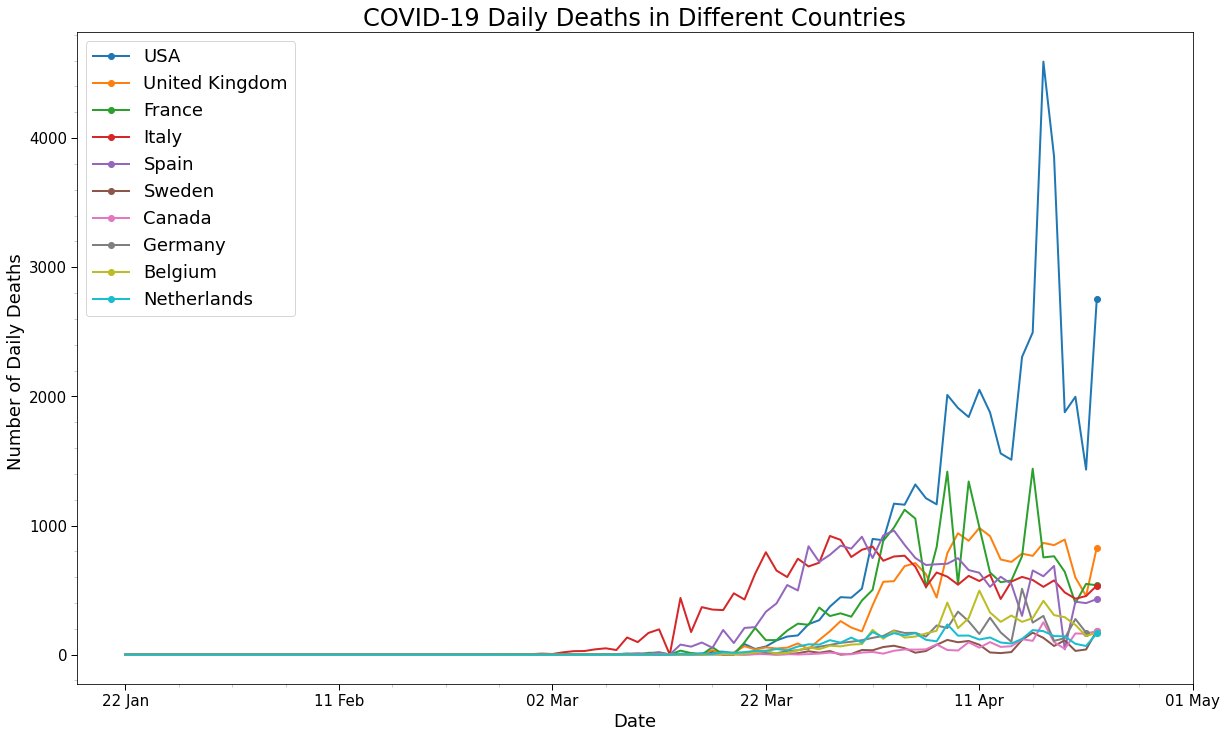

In [0]:
temp = df_deaths.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=15)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')



plt.title("COVID-19 Daily Deaths in Different Countries",{'fontsize':24})

plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths ",fontsize =18)


plt.legend(fontsize=18) 
plt.savefig(out+"daily deaths countrywise.png")
plt.show()

Confirmed and Deaths cases in Different countries



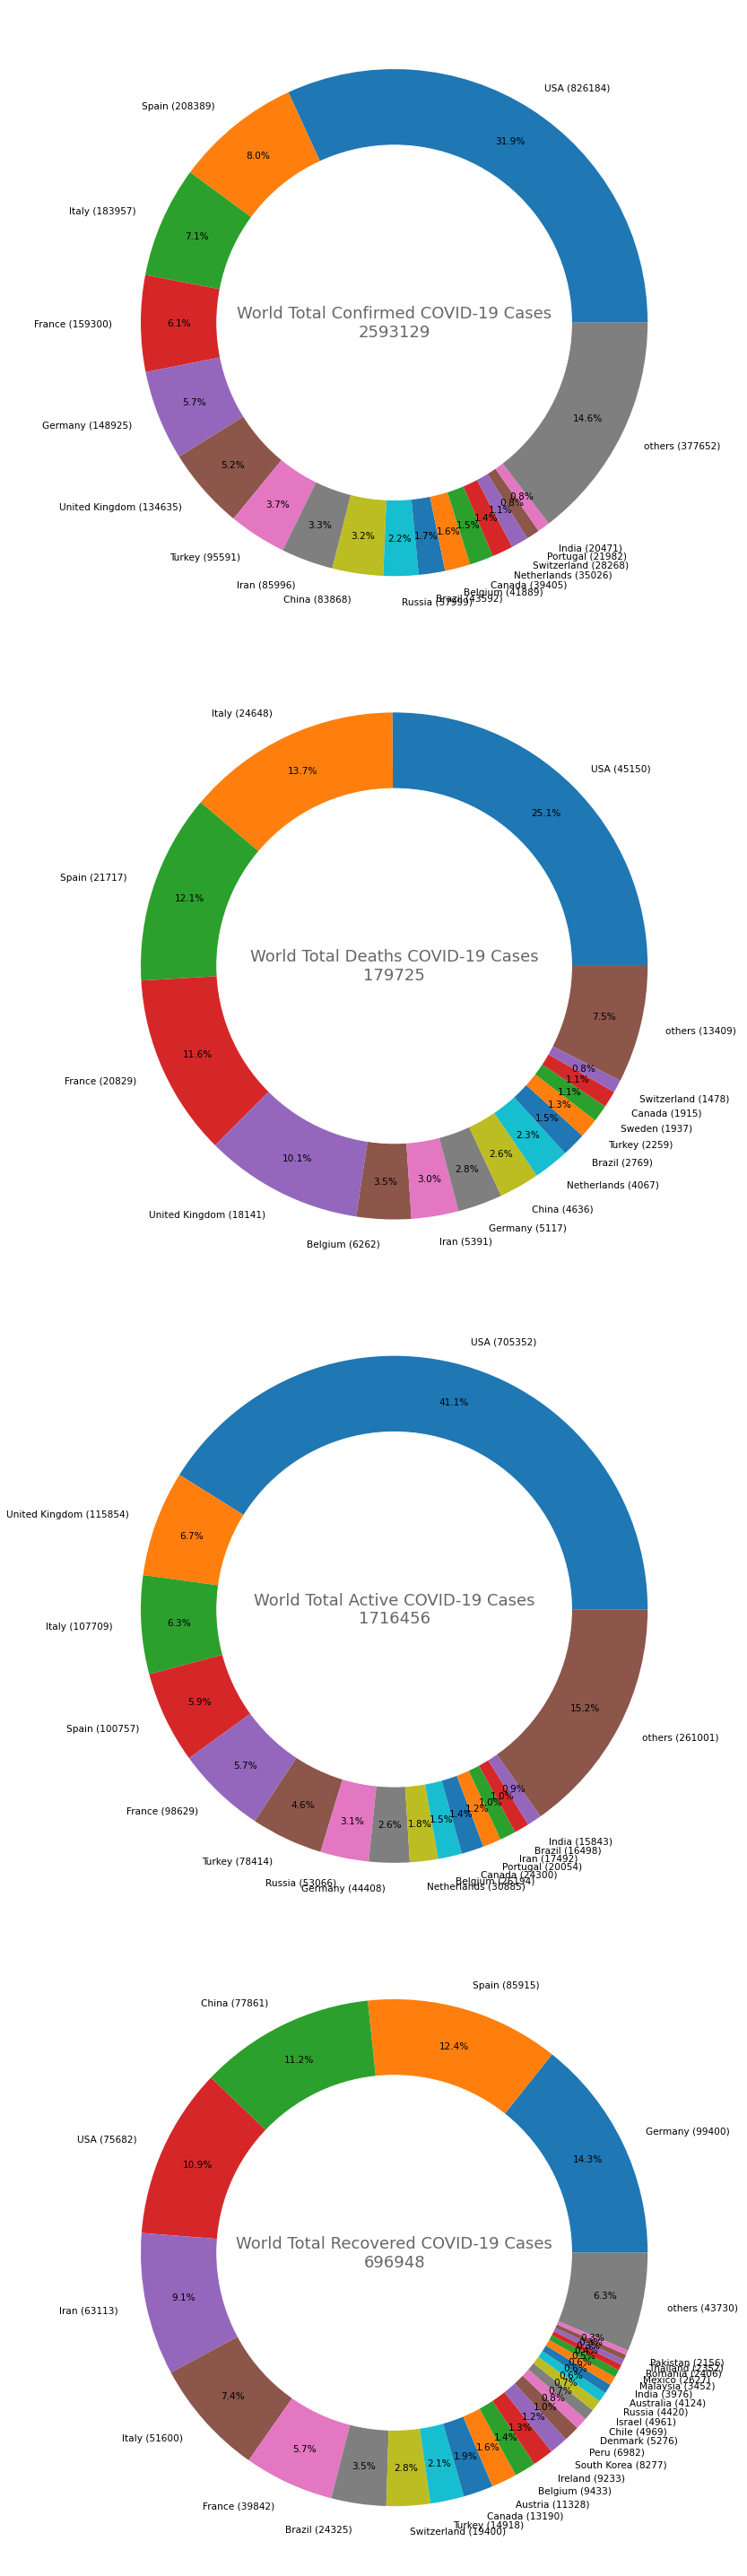

In [0]:
rows = 4
f = plt.figure(figsize=(15,10*rows))

stats = [df_covid19.loc[:,['country','Confirmed']],df_covid19.loc[:,['country','Deaths']],df_covid19.loc[:,['country','Active']],df_covid19.loc[:,['country','Recovered']]]
label = ["Confirmed","Deaths","Active","Recovered"]
threshold = [20000,1000,15000,2000]
for i, stat in enumerate(stats):
    plt.tight_layout()
    df_countries = stat.groupby(["country"]).sum()
    df_countries = df_countries.sort_values(df_countries.columns[-1],ascending= False)
    others = df_countries[df_countries[df_countries.columns[-1]] < threshold[i] ].sum()[-1]
    df_countries = df_countries[df_countries[df_countries.columns[-1]] > threshold[i]]
    df_countries = df_countries[df_countries.columns[-1]]
    df_countries["others"] = others
    labels = [df_countries.index[i] +" (" + str(int(df_countries[i])) +") "for i in range(df_countries.shape[0])]

    ax = f.add_subplot(rows,1,i+1)
    plt.pie(df_countries, labels=labels,autopct='%1.1f%%',pctdistance=0.85, labeldistance=1.1,textprops = {'fontsize':10.5})
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.text(0.5,0.5,"World Total "+label[i]+ " COVID-19 Cases\n"+str(stat.sum().values[1]), horizontalalignment='center',verticalalignment='center',transform=ax.transAxes, size=18, alpha = 0.6)


plt.show()
